In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import sys
import matplotlib
import seaborn as sns
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

In [222]:
from scipy import stats

In [223]:
pd.set_option('max_rows', 100)

# Import Data

In [224]:
## Read in all files from TAQ

# Fix forward/backslashes in directory name
taq_folder = '../data/clean/ticker_1s/'
if sys.platform != 'linux':
    taq_folder = taq_folder.replace('/', '\\')
print(f'Reading data from: {taq_folder}')

# Read files
taq_files = [x[2] for x in tqdm(os.walk(taq_folder))][0]
ticker_1s = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files])

Reading data from: ..\data\clean\ticker_1s\


In [225]:
ticker_1s.groupby('ticker').head()

,ticker,ticker_desc,date,datetime,price,log_price,return
0,GOOG,Google,2019-09-20,2019-09-20 09:30:00,1234.260,7.118227,0.000000
1,GOOG,Google,2019-09-20,2019-09-20 09:30:01,1235.350,7.119110,0.000883
2,GOOG,Google,2019-09-20,2019-09-20 09:30:02,1236.050,7.119676,0.000566
3,GOOG,Google,2019-09-20,2019-09-20 09:30:03,1235.180,7.118972,-0.000704
4,GOOG,Google,2019-09-20,2019-09-20 09:30:04,1236.010,7.119644,0.000672
0,FB,Facebook,2019-09-20,2019-09-20 09:30:00,190.620,5.250282,0.000000
1,FB,Facebook,2019-09-20,2019-09-20 09:30:01,190.625,5.250308,0.000026
2,FB,Facebook,2019-09-20,2019-09-20 09:30:02,190.900,5.251749,0.001441
3,FB,Facebook,2019-09-20,2019-09-20 09:30:03,190.850,5.251488,-0.000262
4,FB,Facebook,2019-09-20,2019-09-20 09:30:04,190.750,5.250964,-0.000524


In [227]:
ticker_1s.to_csv('../data/clean_merge/ticker_1s_df.csv')

In [228]:
ticker_1s.query('ticker == "GOOG" and date == "2019-09-20"').head()

,ticker,ticker_desc,date,datetime,price,log_price,return
0,GOOG,Google,2019-09-20,2019-09-20 09:30:00,1234.26,7.118227,0.000000
1,GOOG,Google,2019-09-20,2019-09-20 09:30:01,1235.35,7.119110,0.000883
2,GOOG,Google,2019-09-20,2019-09-20 09:30:02,1236.05,7.119676,0.000566
3,GOOG,Google,2019-09-20,2019-09-20 09:30:03,1235.18,7.118972,-0.000704
4,GOOG,Google,2019-09-20,2019-09-20 09:30:04,1236.01,7.119644,0.000672


In [229]:
def re_resample_data(data,sampling_freq):
    # Fix datetime type
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.sort_values(by=["ticker", "date", "datetime"])
    
    # Resample on a given basis
    resample=(
    data.set_index("datetime")
    .groupby(["ticker", "ticker_desc", "date"])
    .resample(sampling_freq,label = 'right',closed='right')["price"]
    .last()
    .reset_index().copy()
    )
    
    # Forward fill missing prices for particular intervals using last observed price
    resample["price"] = (
    resample.sort_values(by="datetime")
    .groupby(["ticker", "ticker_desc", "date"])["price"]
    .fillna(method="ffill")
    )
    
#ticker_1s_df.groupby('ticker').apply(lambda i:i.iloc[0])    
#     # Add price of time == 0
   
#     df = data.groupby(["ticker", "ticker_desc", "date"]).first().reset_index().copy()
#     df=(
#     df.set_index("datetime")
#     .groupby(["ticker", "ticker_desc", "date"])
#     .resample(sampling_freq,label = 'left')["price"]
#     .last()
#     .reset_index().copy()
#     )
#     #df = df[["ticker", "ticker_desc", "date", "datetime", "price"]]
#     resample = pd.concat([df,resample]).copy()
    
    
    # Add returns
    resample = resample.sort_values(by=["ticker", "date", "datetime"])
    resample["log_price"] = np.log(resample["price"])
    resample["return"] = resample.groupby(["ticker", "date"])["log_price"].diff(1).fillna(0)
    
    return resample

# Create 5min data

In [230]:
ticker_5min = re_resample_data(ticker_1s,sampling_freq='300s').copy()

In [231]:
ticker_5min.groupby('ticker').head()

,ticker,ticker_desc,date,datetime,price,log_price,return
0,AAPL,Apple,2019-09-20,2019-09-20 09:30:00,221.39,5.399926,0.000000
1,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.16,5.403398,0.003472
2,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.23,5.403713,0.000315
3,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.98,5.402587,-0.001126
4,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.68,5.401235,-0.001352
19908,AMZN,Amazon,2019-09-20,2019-09-20 09:30:00,1821.71,7.507531,0.000000
19909,AMZN,Amazon,2019-09-20,2019-09-20 09:35:00,1823.58,7.508557,0.001026
19910,AMZN,Amazon,2019-09-20,2019-09-20 09:40:00,1829.19,7.511629,0.003072
19911,AMZN,Amazon,2019-09-20,2019-09-20 09:45:00,1830.00,7.512071,0.000443
19912,AMZN,Amazon,2019-09-20,2019-09-20 09:50:00,1826.09,7.509932,-0.002139


In [232]:
ticker_5min.to_csv('../data/clean_merge/ticker_5min_df.csv', index = False)

In [234]:
ticker_5min.query("ticker=='GOOG'").head(20)

,ticker,ticker_desc,date,datetime,price,log_price,return
59722,GOOG,Google,2019-09-20,2019-09-20 09:30:00,1234.26,7.118227,0.000000
59723,GOOG,Google,2019-09-20,2019-09-20 09:35:00,1237.76,7.121059,0.002832
59724,GOOG,Google,2019-09-20,2019-09-20 09:40:00,1241.78,7.124301,0.003243
59725,GOOG,Google,2019-09-20,2019-09-20 09:45:00,1242.29,7.124712,0.000411
59726,GOOG,Google,2019-09-20,2019-09-20 09:50:00,1237.88,7.121156,-0.003556
59727,GOOG,Google,2019-09-20,2019-09-20 09:55:00,1236.75,7.120242,-0.000913
59728,GOOG,Google,2019-09-20,2019-09-20 10:00:00,1238.52,7.121672,0.001430
59729,GOOG,Google,2019-09-20,2019-09-20 10:05:00,1238.74,7.121850,0.000178
59730,GOOG,Google,2019-09-20,2019-09-20 10:10:00,1238.97,7.122036,0.000186
59731,GOOG,Google,2019-09-20,2019-09-20 10:15:00,1238.33,7.121519,-0.000517


# RV

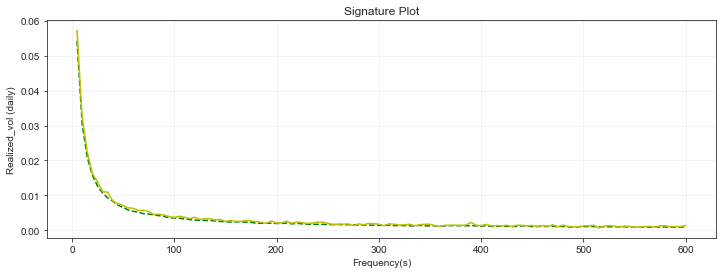

In [300]:
result_rv = {}
for i,j in tqdm(rv.items()):
    #result_rv[i*step] = j.mean()
     result_rv[i*step] = j[0]

result_rv_avg = {}
for i,j in tqdm(rv.items()):
    result_rv_avg[i*step] = j.mean()
    #result_rv[i*step] = j[0]

df_rv=pd.DataFrame.from_dict(result_rv, orient='index').reset_index().rename(columns={0:'daily_rv','index':'freq(s)'})
df_rv_avg=pd.DataFrame.from_dict(result_rv_avg, orient='index').reset_index().rename(columns={0:'daily_rv(avg)','index':'freq(s)'})

plt.figure(figsize=(12,4))
plt.plot('freq(s)','daily_rv(avg)',data=df_rv_avg,c='g',ls='--')
plt.plot('freq(s)','daily_rv',data=df_rv,c='y')
plt.xlabel('Frequency(s)');plt.ylabel('Realized_vol (daily)');plt.title('Signature Plot')
plt.show()

###### Pick 5 minute frequency data

# Compute standard rrror

#### $$se= \sqrt{\frac{1}{3} \cdot 2 \cdot \sum_{i=0}^{\frac{T}{\Delta_n}} r_i^4}$$

In [240]:
df = ticker_5min.copy()

In [278]:
rv={}
df['return_power2'] = np.square(df['return'])
df['return_power4']=np.power(df['return'],4)

rv['return_power2'] = df.groupby(['ticker','date'])['return_power2'].sum()
rv['return_power4'] = df.groupby(['ticker','date'])['return_power4'].sum()
rv['rv'] = df.groupby(['ticker','date'])['return_power2'].sum() #daily rv with sample freq = i
rv['se'] = np.sqrt(2*df.groupby(['ticker','date'])['return_power4'].sum()/3)
df_rv = pd.DataFrame.from_dict(rv).reset_index()
df_rv['rvol'] = np.sqrt(df_rv['rv'])

In [279]:
# Confidence interval
for i,j in zip([0.995, 0.975, 0.95],[99,95,90]):
    c = stats.norm.ppf(i)
    df_rv['lower_{}'.format(str(j))] = df_rv['rv'] - c*df_rv['se']
    df_rv['upper_{}'.format(str(j))] = df_rv['rv'] + c*df_rv['se']

In [280]:
df_rv.query('ticker == "GOOG" and date >= "2020-08-03"').head()

,ticker,date,return_power2,return_power4,rv,se,rvol,lower_99,upper_99,lower_95,upper_95,lower_90,upper_90
974,GOOG,2020-08-03,0.000735,2.161221e-08,0.000735,0.000120,0.027118,0.000426,0.001045,0.000500,0.000971,0.000538,0.000933
975,GOOG,2020-08-04,0.000913,2.898236e-08,0.000913,0.000139,0.030211,0.000555,0.001271,0.000640,0.001185,0.000684,0.001141
976,GOOG,2020-08-05,0.000981,3.077982e-08,0.000981,0.000143,0.031323,0.000612,0.001350,0.000700,0.001262,0.000745,0.001217
977,GOOG,2020-08-06,0.000407,7.942057e-09,0.000407,0.000073,0.020184,0.000220,0.000595,0.000265,0.000550,0.000288,0.000527
978,GOOG,2020-08-07,0.000475,6.789206e-09,0.000475,0.000067,0.021795,0.000302,0.000648,0.000343,0.000607,0.000364,0.000586


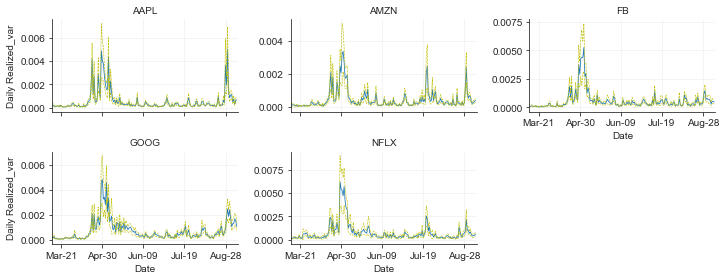

In [381]:
# plot confidence interval
# Plot Daily RV
g = sns.FacetGrid(df_rv, col = 'ticker', col_wrap = 3, sharex = True, aspect = 1.7, height = 2, sharey=False)
g = (g.map(plt.plot,'date', 'rv',lw=0.8)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'lower_95',color='y',ls='--', lw=0.6)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'upper_95',color='y',ls='--',lw=0.6)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)


# # Plot settings
ax = g.axes.flatten()
for i in range(5):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

plt.xlim(xmin='2020-01-02')
plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-02', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

plt.tight_layout()
plt.savefig("../exhibits/rv_ci.pdf")


## Single asset

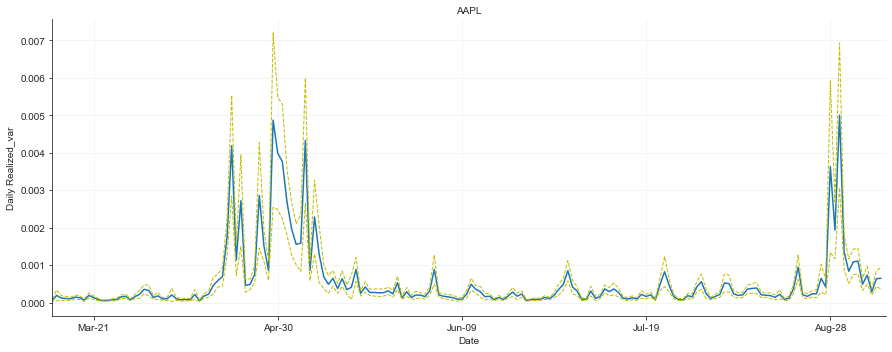

In [394]:
g = sns.FacetGrid(df_rv.query('ticker == "AAPL"'), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'rv')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'lower_95',color='y',ls='--', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'upper_95',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)

#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

plt.xlim(xmin='2020-01-02')
plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/aapl_rv_ci.pdf", dpi=300)

## Sample T = 5d, 10d, 20d

In [251]:
df_rv.head()

,ticker,date,rv,se,rvol,lower_99,upper_99,lower_95,upper_95,lower_90,upper_90
0,AAPL,2019-09-20,0.000209,0.000055,0.014448,0.000068,0.000350,0.000101,0.000316,0.000119,0.000299
1,AAPL,2019-09-23,0.000084,0.000022,0.009165,0.000027,0.000141,0.000040,0.000128,0.000047,0.000121
2,AAPL,2019-09-24,0.000234,0.000040,0.015295,0.000130,0.000338,0.000155,0.000313,0.000168,0.000300
3,AAPL,2019-09-25,0.000077,0.000016,0.008797,0.000036,0.000119,0.000046,0.000109,0.000051,0.000104
4,AAPL,2019-09-26,0.000075,0.000016,0.008669,0.000033,0.000117,0.000043,0.000107,0.000048,0.000102


In [480]:
# T=5
temp = df_rv.copy()
temp['date'] = pd.to_datetime(temp['date'])
rv = {}
for T in tqdm([1,5,10,20]): 
    temp['return_power2_{}d'.format(str(T))]=temp.groupby('ticker')[['return_power2']].rolling(T).sum().reset_index(drop=True)
    temp['return_power4_{}d'.format(str(T))]=temp.groupby('ticker')[['return_power4']].rolling(T).sum().reset_index(drop=True)
    rv[T] = temp.copy().groupby('ticker')['return_power2_{}d'.format(str(T)),'return_power4_{}d'.format(str(T)), 'date'].apply(lambda i:i.iloc[T-1:252:T])


In [481]:
df_rv_1 = pd.DataFrame.from_dict(rv[1]).reset_index(drop=False).drop(columns='level_1')
df_rv_5 = pd.DataFrame.from_dict(rv[5]).reset_index(drop=False).drop(columns='level_1')
df_rv_10 = pd.DataFrame.from_dict(rv[10]).reset_index(drop=False).drop(columns='level_1')
df_rv_20 = pd.DataFrame.from_dict(rv[20]).reset_index(drop=False).drop(columns='level_1')

In [482]:
df_rv_1.head()

,ticker,return_power2_1d,return_power4_1d,date
0,AAPL,0.000209,4.504778e-09,2019-09-20
1,AAPL,0.000084,7.454786e-10,2019-09-23
2,AAPL,0.000234,2.427866e-09,2019-09-24
3,AAPL,0.000077,3.846456e-10,2019-09-25
4,AAPL,0.000075,3.944198e-10,2019-09-26


In [483]:
df_rv_10.head()

,ticker,return_power2_10d,return_power4_10d,date
0,AAPL,0.001497,2.845188e-08,2019-10-03
1,AAPL,0.000856,6.929195e-09,2019-10-17
2,AAPL,0.000960,9.144386e-09,2019-10-31
3,AAPL,0.000560,2.519898e-09,2019-11-14
4,AAPL,0.000618,6.040377e-09,2019-11-29


In [498]:
df_rv_1['annul_rv'] = df_rv_1['return_power2_1d'] * 252
df_rv_1['annul_se'] = np.sqrt(2*df_rv_1['return_power4_1d'] * 252/3)

In [499]:
df_rv_5['annul_rv'] = df_rv_5['return_power2_5d'] * 252/5
df_rv_5['annul_se'] = np.sqrt(2*df_rv_5['return_power4_5d'] * 252/5/3)

df_rv_10['annul_rv'] = df_rv_10['return_power2_10d'] * 252/10
df_rv_10['annul_se'] = np.sqrt(2*df_rv_10['return_power4_10d'] * 252/10/3)

df_rv_20['annul_rv'] = df_rv_20['return_power2_20d'] * 252/20
df_rv_20['annul_se'] = np.sqrt(2*df_rv_20['return_power4_20d'] * 252/20/3)

In [500]:
df_rv_1['day'] = 1
df_rv_5['day'] = 5
df_rv_10['day'] = 10
df_rv_20['day'] = 20

In [501]:
df5_10 = df_rv_5.merge(df_rv_10, how = 'outer', left_on = ['ticker','date','day','annul_rv','annul_se'], right_on = ['ticker','date','day','annul_rv','annul_se'])
df5_10_20 = df_rv_20.merge(df5_10, how = 'outer', left_on = ['ticker','date','day','annul_rv','annul_se'], right_on = ['ticker','date','day','annul_rv','annul_se'])

In [502]:
df1_5_10_20 = df_rv_1.merge(df5_10_20, how = 'outer', left_on = ['ticker','date','day','annul_rv','annul_se'], right_on = ['ticker','date','day','annul_rv','annul_se'])

In [506]:
df1_5_10_20 = df1_5_10_20.sort_values(by=['ticker','date','day'])

In [507]:
df1_5_10_20.head()

,ticker,return_power2_1d,return_power4_1d,date,annul_rv1,annul_se1,day,annul_rv,annul_se,return_power2_20d,...,annul_rv20,annul_se20,return_power2_5d,return_power4_5d,annul_rv5,annul_se5,return_power2_10d,return_power4_10d,annul_rv10,annul_se10
0,AAPL,0.000209,4.504778e-09,2019-09-20,0.052602,0.000870,1,0.052602,0.000870,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,0.000084,7.454786e-10,2019-09-23,0.021166,0.000354,1,0.021166,0.000354,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,0.000234,2.427866e-09,2019-09-24,0.058949,0.000639,1,0.058949,0.000639,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,0.000077,3.846456e-10,2019-09-25,0.019502,0.000254,1,0.019502,0.000254,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,0.000075,3.944198e-10,2019-09-26,0.018937,0.000257,1,0.018937,0.000257,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
plot_data = df1_5_10_20.query("ticker == 'AAPL' and day == 1")

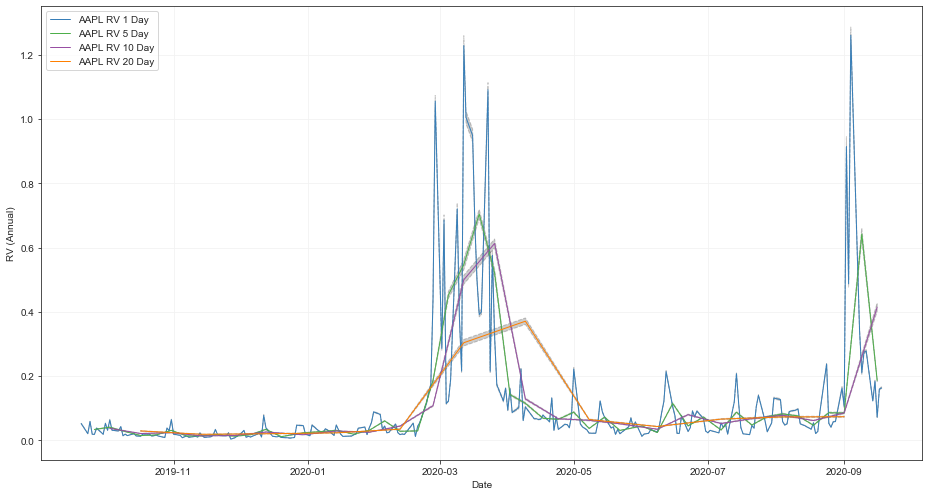

In [587]:
fig, ax = plt.subplots(figsize=(13, 7), sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    #ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'AAPL' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        dashes=[(5, i)],
        color=sns.color_palette("Set1", 5)[i+1],
        label= 'AAPL RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'AAPL' and day == @day"),
        ax=ax,
        **{"lw": 1},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        ls='--',
        color="k",
        alpha=0.2,
       # label="FB RV 90% CI",
        
    )
    plt.legend(loc="upper left", fontsize=10)
   
#     if i < 3:
#         ax.axes.get_xaxis().set_visible(False)

    plt.ylabel("RV (Annual)")
    plt.xlabel("Date") 

plt.tight_layout()
plt.savefig("../exhibits/aapl_rv_se.pdf")

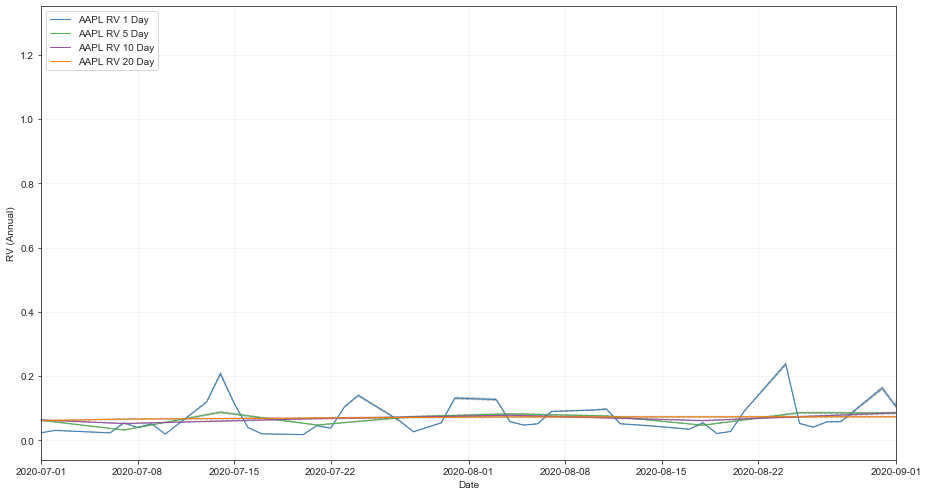

In [588]:
fig, ax = plt.subplots(figsize=(13, 7), sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    #ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'AAPL' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        dashes=[(5, i)],
        color=sns.color_palette("Set1", 5)[i+1],
        label= 'AAPL RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'AAPL' and day == @day"),
        ax=ax,
        **{"lw": 1},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        ls='--',
        color="k",
        alpha=0.2,
       # label="FB RV 90% CI",
        
    )
    plt.legend(loc="upper left", fontsize=10)
   
#     if i < 3:
#         ax.axes.get_xaxis().set_visible(False)

    plt.ylabel("RV (Annual)")
    plt.xlabel("Date") 
    
    plt.xlim(pd.to_datetime("2020-07-01"), plot_data["date"].max())

plt.tight_layout()
plt.savefig("../exhibits/aapl_rv_se.pdf")

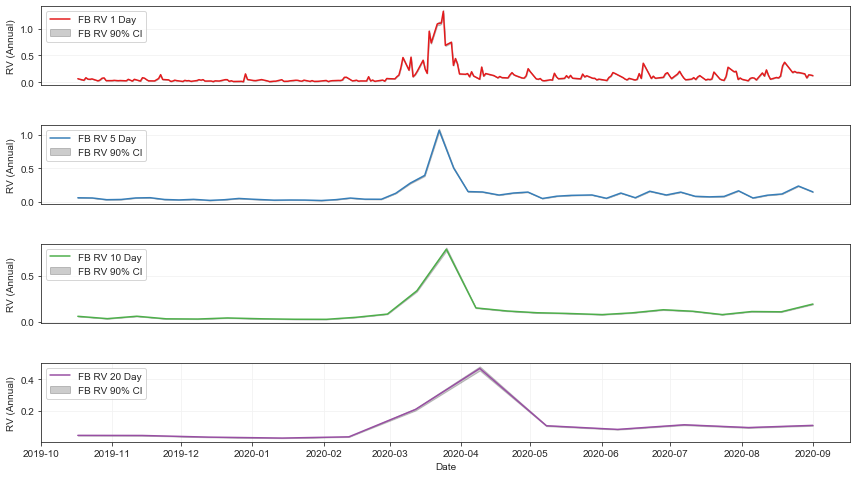

In [545]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=4, ncols=1, sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'FB' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        color=sns.color_palette("Set1", 5)[i],
        label= 'FB RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'FB' and day == @day"),
        ax=ax,
        **{"lw": 1.5},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="FB RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)

    if i < 3:
        ax.axes.get_xaxis().set_visible(False)

    plt.ylabel("RV (Annual)")
plt.xlabel("Date") 

plt.tight_layout()
plt.savefig("../exhibits/fb_rv_se.pdf")

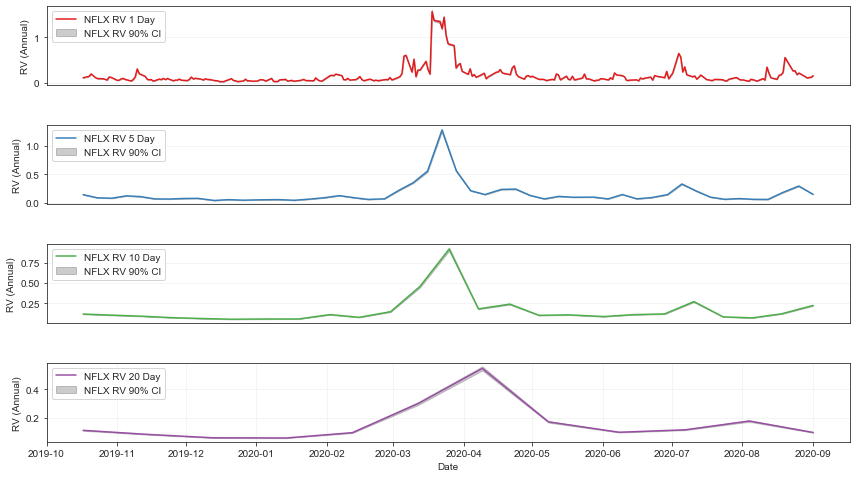

In [546]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=4, ncols=1, sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'NFLX' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        color=sns.color_palette("Set1", 5)[i],
        label= 'NFLX RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'NFLX' and day == @day"),
        ax=ax,
        **{"lw": 1.5},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="NFLX RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)

    if i < 3:
        ax.axes.get_xaxis().set_visible(False)

    plt.ylabel("RV (Annual)")
plt.xlabel("Date") 

plt.tight_layout()
plt.savefig("../exhibits/nflx_rv_se.pdf")

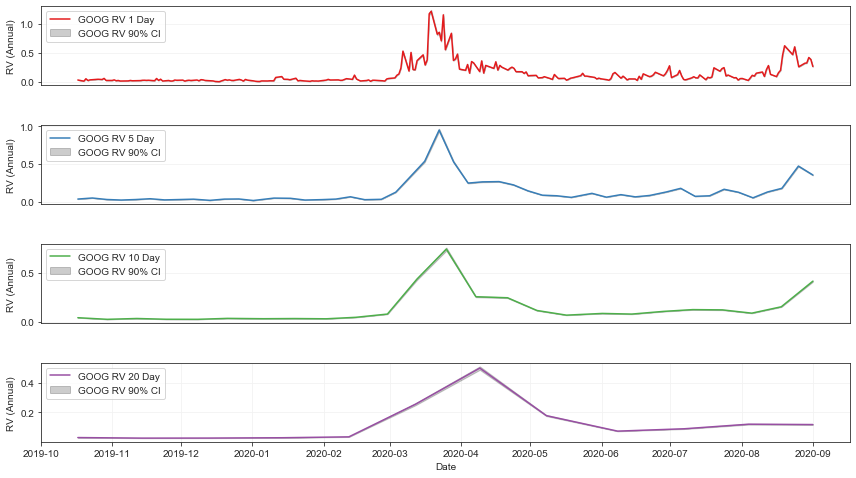

In [547]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=4, ncols=1, sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'GOOG' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        color=sns.color_palette("Set1", 5)[i],
        label= 'GOOG RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'GOOG' and day == @day"),
        ax=ax,
        **{"lw": 1.5},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="GOOG RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)

    if i < 3:
        ax.axes.get_xaxis().set_visible(False)

    plt.ylabel("RV (Annual)")
plt.xlabel("Date") 

plt.tight_layout()
plt.savefig("../exhibits/goog_rv_se.pdf")

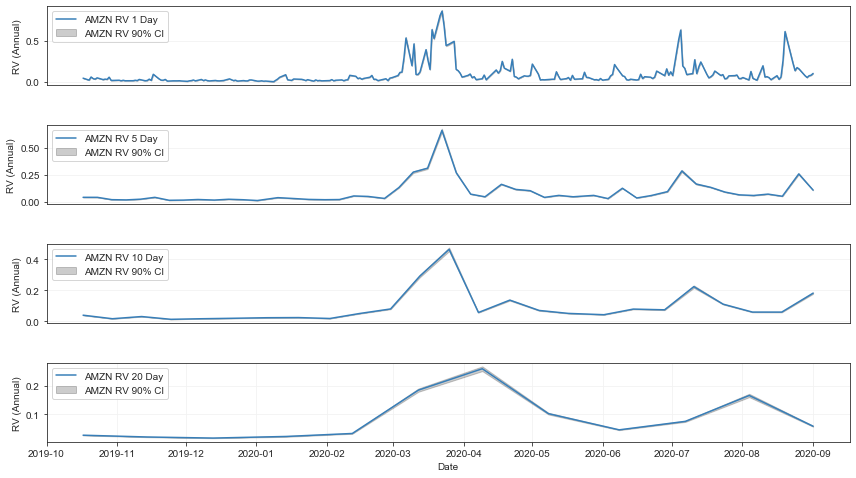

In [551]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=4, ncols=1, sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'AMZN' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        color=sns.color_palette("Set1", 5)[1],
        label= 'AMZN RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'AMZN' and day == @day"),
        ax=ax,
        **{"lw": 1.5},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="AMZN RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)
    
    

    
    if i < 3:
        ax.axes.get_xaxis().set_visible(False)

        
    plt.ylabel("RV (Annual)")  
plt.xlabel("Date") 

plt.tight_layout()
plt.savefig("../exhibits/amzn_rv_se.pdf")

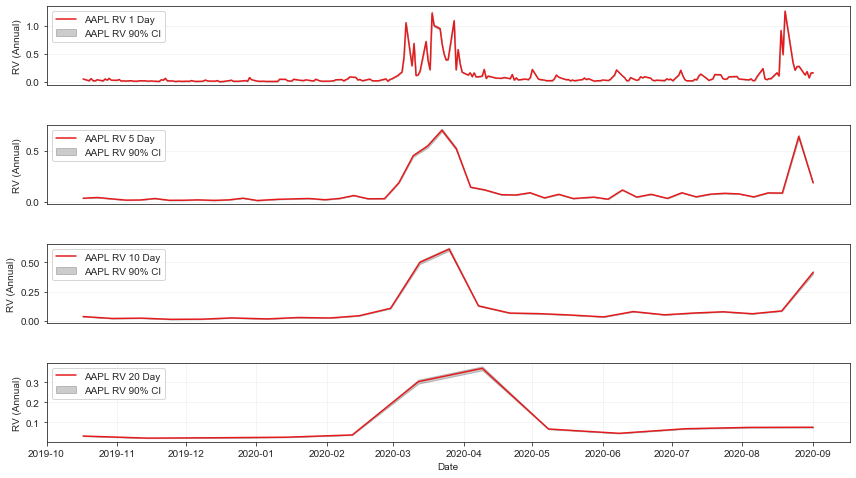

In [550]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=4, ncols=1, sharex=True, sharey=True)

days = df1_5_10_20["day"].unique()

# Plot RV for each series
for i in range(len(days)):

    day = days[i]

    ax = plt.subplot(5, 1, i + 1)
    #plt.ylim(0, 0.0075)
    plot_data = df1_5_10_20.query("ticker == 'AAPL' and day == @day")

    sns.lineplot(
        x="date",
        y="annul_rv",
        color=sns.color_palette("Set1", 5)[0],
        label= 'AAPL RV ' + str(day) +' Day',
        data = df1_5_10_20.query("ticker == 'AAPL' and day == @day"),
        ax=ax,
        **{"lw": 1.5},
    )

    #90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.05),
        plot_data["annul_rv"] + plot_data["annul_se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="AAPL RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)

    if i < 3:
        ax.axes.get_xaxis().set_visible(False)

    plt.ylabel("RV (Annual)")
plt.xlabel("Date") 

plt.tight_layout()
plt.savefig("../exhibits/aapl_rv_se.pdf")

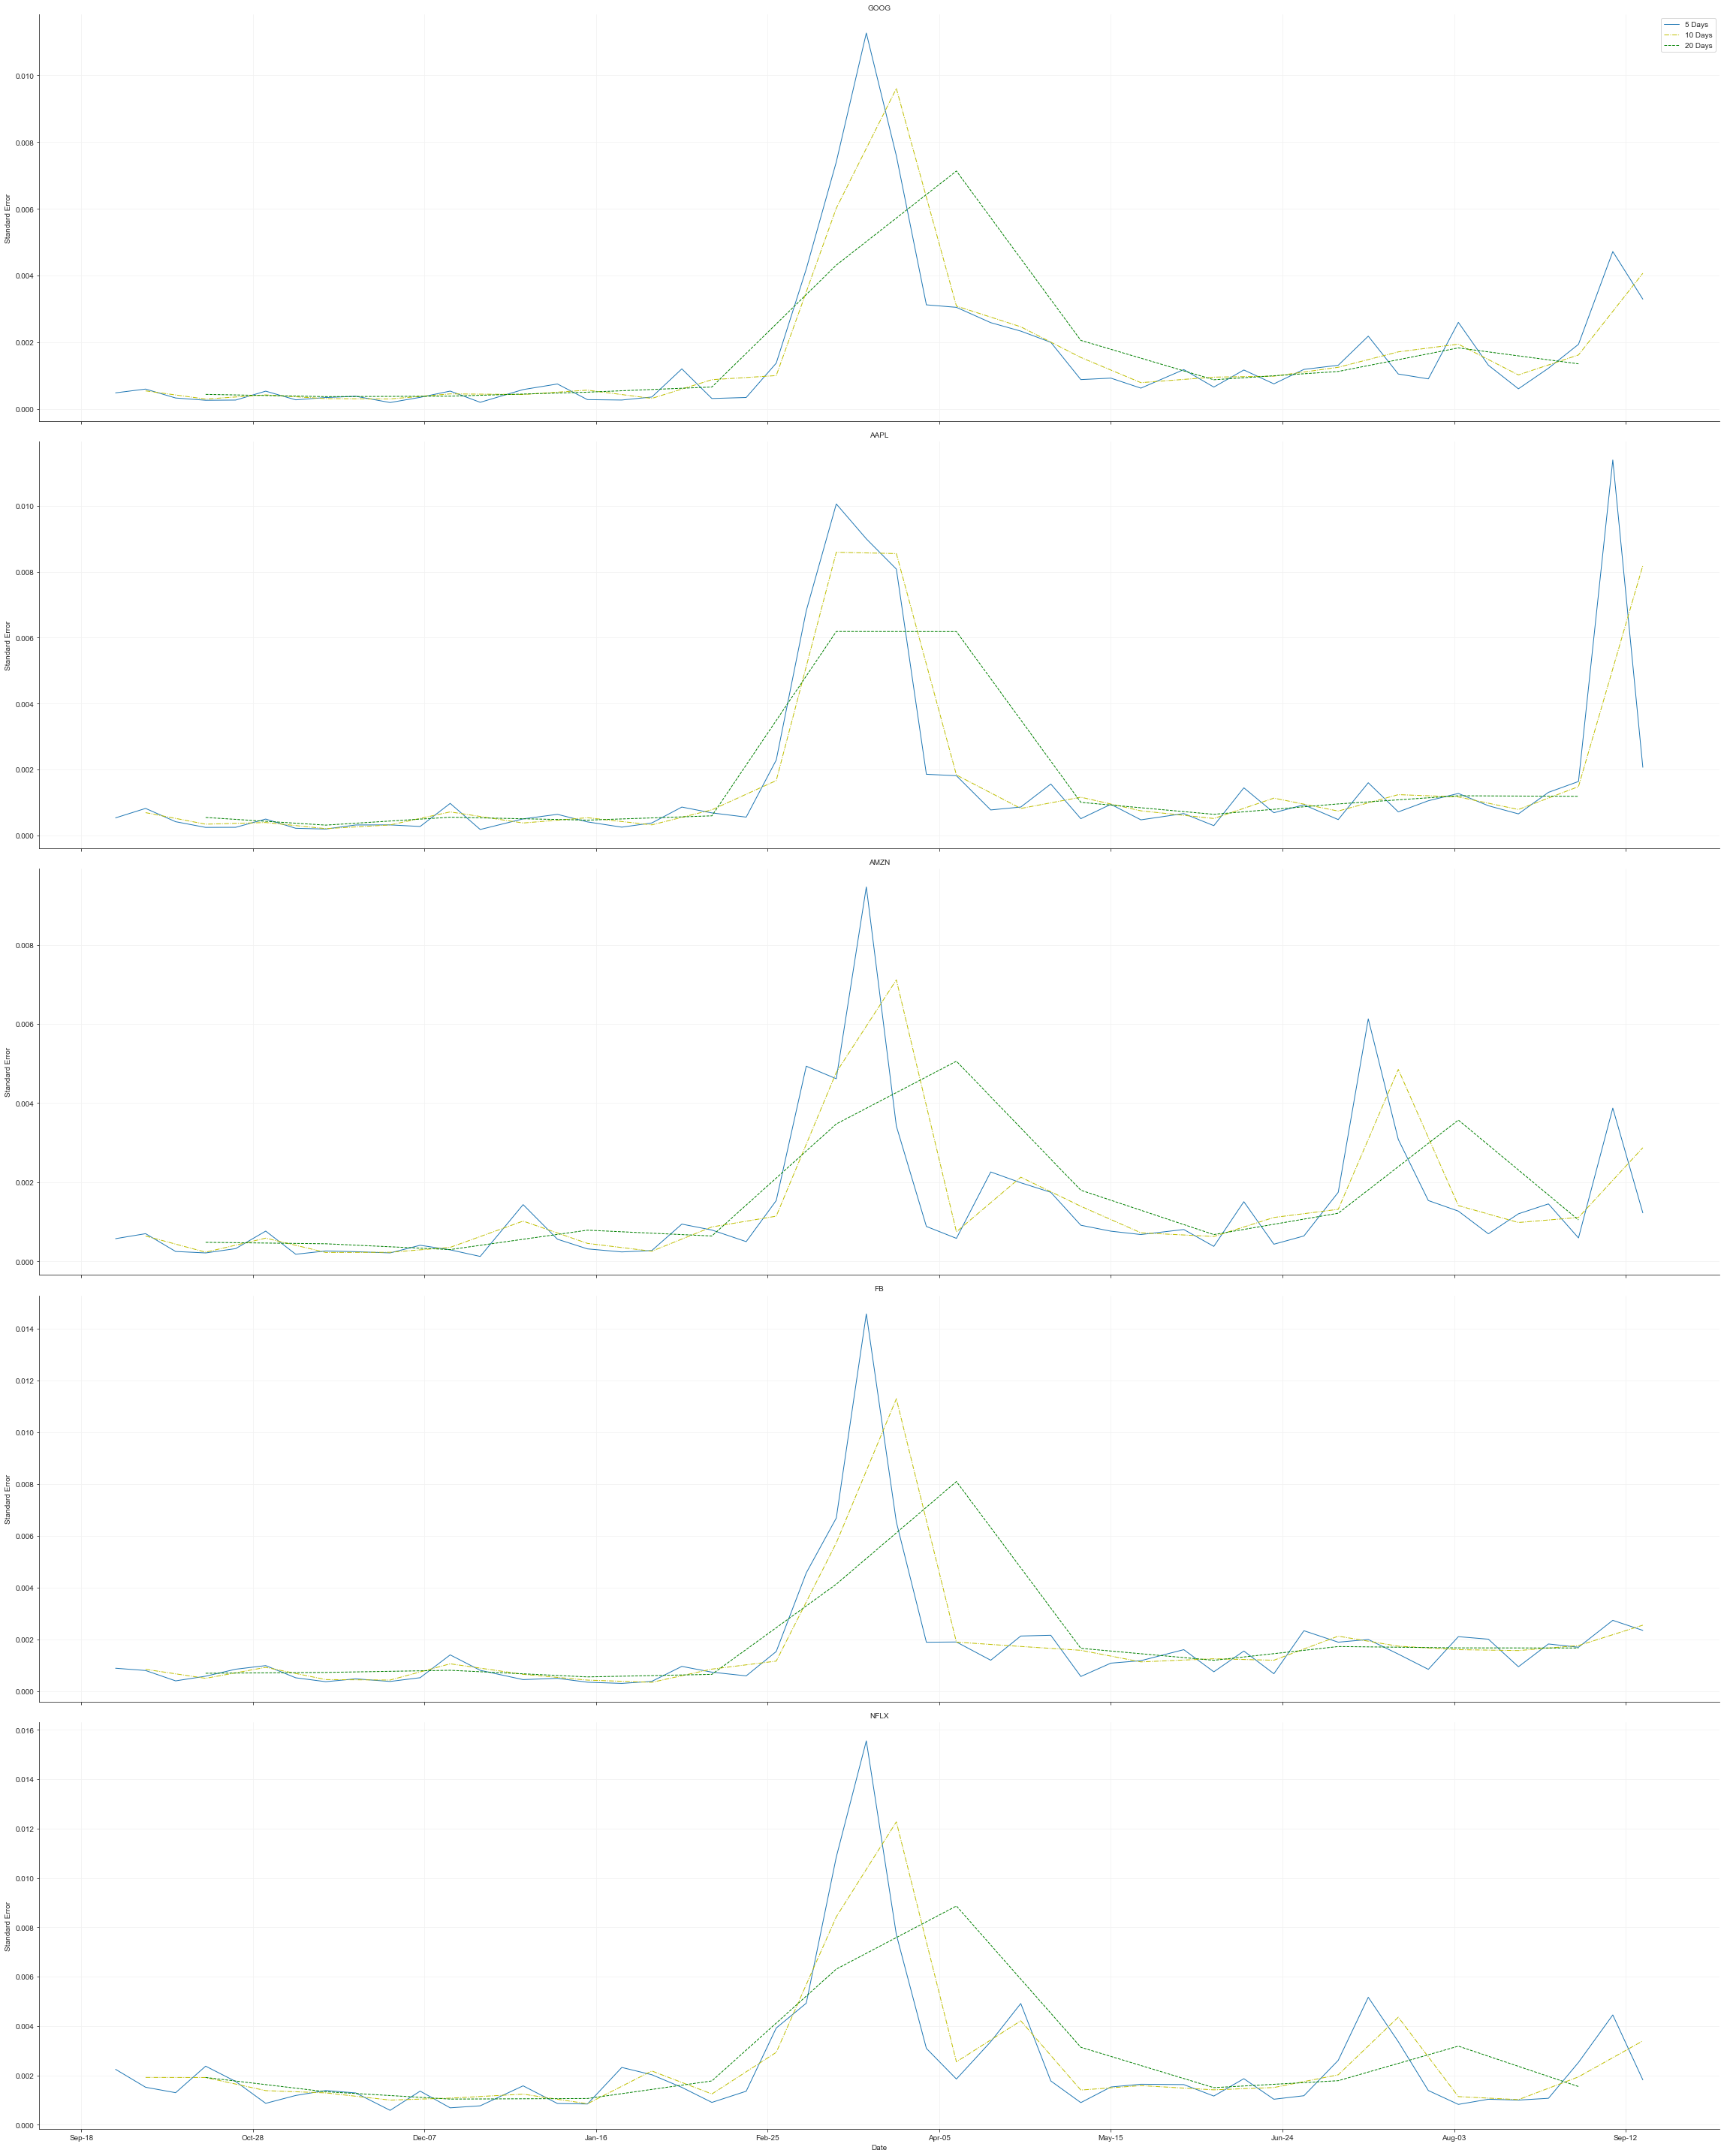

In [448]:
# plot confidence interval
# Plot se
g1 = sns.FacetGrid(df1_5_10_20, col = 'ticker', col_wrap = 1, sharex = True, aspect = 4, height = 8, sharey=False)
g1 = (g1.map(plt.plot,'date', 'annul_se_x',lw=1,label = '5 Days')
    .set_titles("{col_name}")
)

g1 = (g1.map(plt.plot,'date', 'annul_se_y',lw=1, color='y',ls='-.',label = '10 Days')
    .set_titles("{col_name}")
)

g1 = (g1.map(plt.plot,'date', 'annul_se',lw=1, color='g', ls='--',label = '20 Days')
    .set_titles("{col_name}")
    .set_axis_labels("Date", "Standard Error")
)

# # Plot settings
ax = g1.axes.flatten()
for i in range(5):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    
ax[0].legend()
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-02', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

plt.tight_layout()
plt.savefig("../exhibits/se.pdf")


In [458]:
df_rv_5['day'] = 5
df_rv_10['day'] = 10
df_rv_20['day'] = 20

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=5, ncols=1, sharex=True, sharey=True)

tickers = df_rv_5["ticker"].unique()

# Plot RV for each series
for i in range(len(tickers)):

    ticker = tickers[i]

    ax = plt.subplot(5, 1, i + 1)
    plt.ylim(0, 0.0075)
    plot_data = data_daily_df.query("ticker == @ticker")

    sns.lineplot(
        x="date",
        y="RV",
        color=sns.color_palette("Set1", 5)[i],
        label=ticker + " RV",
        data=data_daily_df.query("ticker == @ticker"),
        ax=ax,
        **{"lw": 1.5},
    )

    # 90% CI
    plt.fill_between(
        plot_data["date"],
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.05),
        plot_data["RV"] + plot_data["se"] * stats.norm.ppf(0.95),
        color="k",
        alpha=0.2,
        label="AAPL RV 90% CI",
    )
    plt.legend(loc="upper left", fontsize=10)

    if i < 4:
        ax.axes.get_xaxis().set_visible(False)

plt.ylabel("RV (Daily)")
plt.xlabel("Date")

plt.tight_layout()

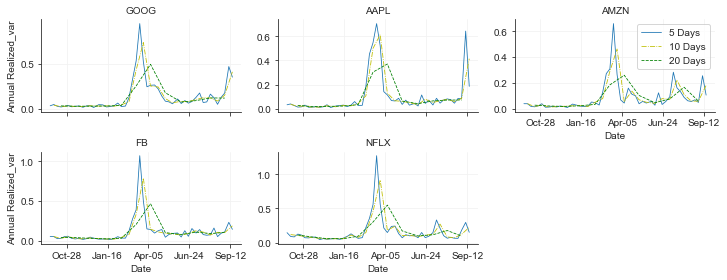

In [386]:
# plot confidence interval
# Plot se
g1 = sns.FacetGrid(df5_10_20, col = 'ticker', col_wrap = 3, sharex = True, aspect = 1.7, height = 2, sharey=False)
g1 = (g1.map(plt.plot,'date', 'annul_rv_x',lw=0.8,label = '5 Days')
    .set_titles("{col_name}")
)

g1 = (g1.map(plt.plot,'date', 'annul_rv_y',lw=0.8, color='y',ls='-.',label = '10 Days')
    .set_titles("{col_name}")
)

g1 = (g1.map(plt.plot,'date', 'annul_rv',lw=0.8, color='g', ls='--',label = '20 Days')
    .set_titles("{col_name}")
    .set_axis_labels("Date", "Annual Realized_var")
)

# # Plot settings
ax = g1.axes.flatten()
for i in range(5):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    
ax[2].legend()
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-02', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

plt.tight_layout()
plt.savefig("../exhibits/rv.pdf")


### confidence interval

In [396]:
# Confidence interval
for i,j in zip([0.995, 0.975, 0.95],[99,95,90]):
    c = stats.norm.ppf(i)
    df_rv_5['lower_{}'.format(str(j))] = df_rv_5['annul_rv'] - c*df_rv_5['annul_se']
    df_rv_5['upper_{}'.format(str(j))] = df_rv_5['annul_rv'] + c*df_rv_5['annul_se']
    df_rv_10['lower_{}'.format(str(j))] = df_rv_10['annul_rv'] - c*df_rv_10['annul_se']
    df_rv_10['upper_{}'.format(str(j))] = df_rv_10['annul_rv'] + c*df_rv_10['annul_se']
    df_rv_20['lower_{}'.format(str(j))] = df_rv_20['annul_rv'] - c*df_rv_20['annul_se']
    df_rv_20['upper_{}'.format(str(j))] = df_rv_20['annul_rv'] + c*df_rv_20['annul_se']

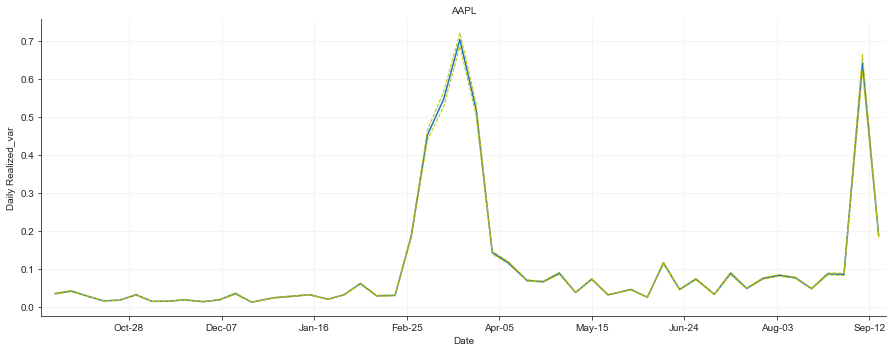

In [405]:
# single stock
# AAPL
g = sns.FacetGrid(df_rv_5.query('ticker == "AAPL"'), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'annul_rv')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'lower_95',color='y',ls='--', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'upper_95',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)

#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

plt.xlim(xmin='2019-09-20')
plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/aapl_rv5_ci.pdf", dpi=300)